$V(x)=\sum_{t=1}^T R(x(t))$ \
where  $R(x)=-\|x-x_{goal}\|-variance$ \
and $T=30$

Use all datas 

# Create Environment

In [27]:
import numpy as np
import matplotlib.pylab as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from tqdm import tqdm

global N

N=50

global M
M=10

global T
global target
T=15
target=np.array([3,2])
global w
w=np.pi*2/23.7

global delta_t
delta_t=T/N

global obs_para
obs_para=6

global beta
beta=[0.95,0.975,1,1.025,1.05]

global num_system
num_system=5


global coeff
coeff=[1 for i in range(N+1)]

In [28]:
def Z(vecs, u, v):
    output=[]
    for i in range(num_system):
        vec=vecs[i]
        x=vec[0]
        y=vec[1]
        theta=vec[2]
        output.append([beta[i]*np.cos(theta)*u,beta[i]*np.sin(theta)*u,beta[i]*v])
    return np.array(output)

#check the correctness of Z
'''
x = np.linspace(0, 6.5, 1001)
plt.plot(x, Z(x))
plt.xlabel('Angle [rad]')
plt.ylabel('Z(theta)')
plt.grid()
plt.show()
'''

"\nx = np.linspace(0, 6.5, 1001)\nplt.plot(x, Z(x))\nplt.xlabel('Angle [rad]')\nplt.ylabel('Z(theta)')\nplt.grid()\nplt.show()\n"

In [29]:
def next_step(vecs,action):  
    u=action[0]
    v=action[1]
   
    for j in range(M):
        vecs_new=[]
        diff=Z(vecs,u,v)
        for i in range(num_system):
            w=vecs[i]+delta_t/M*diff[i]
            '''
            if w[2]>np.pi:
                w[2]-=2*np.pi
            if w[2]<-np.pi:
                w[2]+=2*np.pi
            '''
            vecs_new.append(w)
        vecs=np.array(vecs_new)
    return vecs

def observe(vecs):
    mu_x=0
    mu_y=0
    mu_theta=0
    var_x=0
    var_y=0
    var_theta=0
    for i in range(num_system):
        mu_x+=vecs[i][0]
        mu_y+=vecs[i][1]
        mu_theta+=vecs[i][2]
        var_x+=vecs[i][0]**2
        var_y+=vecs[i][1]**2
        var_theta+=vecs[i][2]**2
    var_x-=mu_x**2/num_system
    var_y-=mu_y**2/num_system
    var_theta-=mu_theta**2/num_system
    
    w=np.array([mu_x,mu_y,mu_theta,var_x,var_y,var_theta])/num_system
    if w[2]>np.pi:
        w[2]-=2*np.pi
    if w[2]<-np.pi:
        w[2]+=2*np.pi
    return w

def reward(obs):
    return max(100-(obs[0]-target[0])**2-(obs[1]-target[1])**2-obs[3]-obs[4],0)

def reward_raw(position):
    r=0
    for i in range(num_system):
        r+=np.linalg.norm(position[i,[0,1]]-target)
    return r

def value_func(funcs,flags,next_state):
    result=[]
    for i in range(6):
        if flags[i]:
            result.append(0)
        else:
            k,_=funcs[i].predict(next_state.reshape(-1,obs_para), return_std=True)
            result.append(k[0])
    result=np.array(result)
    return np.max(result)

# Learning Settings

In [30]:
global lr
lr=0.01
global eps
eps=0.2
global max_u
max_u=2
global precision
precision=0.0002
global action_set
action_set=np.array([[1,np.pi/4],[-1,np.pi/4],[1,0],[-1,0],[1,-np.pi/4],[-1,-np.pi/4]])

def exploration():
    a=np.random.uniform()
    if a<eps:
        return True
    else:
        return False

def find_max(cand):
    return np.argmax(cand)
    
def decide_u(funcs,flags,state,init=False):
    explo=exploration()
    if init or explo:
        return np.random.randint(6)
    else:
        result=[]
        for i in range(6):
            if flags[i]:
                return i
            else:
                k,_=funcs[i].predict(state.reshape(-1,obs_para), return_std=True)
                result.append(k[0])
    result=np.array(result)
    return np.argmax(result)
    
def decide_u_exploitation(funcs,flags,state,init=False):
    result=[]
    for i in range(6):
        if flags[i]:
            print("Err",i)
            return i
        else:
            k,_=funcs[i].predict(state.reshape(-1,obs_para), return_std=True)
            result.append(k[0])
    result=np.array(result)
    return np.argmax(result)

history_su=[0 for i in range(6)]
history_r=[0 for i in range(6)]
history_su_next=[0 for i in range(6)]
flags=[True for i in range(6)]

history_rt=[[[] for i in range(6)] for j in range(N+1)]
history_sut=[[[] for i in range(6)] for j in range(N+1)]
flags_t=[[True for i in range(6)] for j in range(N+1)]

# Simulation


In [31]:
num_iter=80

position_result=[]
observation_result=[]
gpr_list=[[0 for i in range(6)] for j in range(N+1)]

best_r=-10000
best_obs=[]
best_pos=[[] for i in range(num_system)]
best_u=[]

for iterr in tqdm(range(num_iter)):
    #initialize
    position=np.array([[-2,-2,0] for _ in range(num_system)])
    observation=observe(position)
    u_t=[]
    r_t=[]
    observation_t=[observation]
    position_t=[[] for i in range(num_system)]
    
    
    history_target=[0 for i in range(6)]
    
    
    for time in range(N+1):
        if iterr<5:
            #candidates_u=[]
            u_k = decide_u(gpr_list[time],flags,observation,init=True)
            position_new = next_step(position,action_set[u_k])
            observation_new = observe(position_new)
            r = reward(observation_new)
            r_t.append(r)
            
            if flags[u_k]:
                history_su[u_k] = observation.reshape(-1,obs_para)
                history_su_next[u_k] = observation_new.reshape(-1,obs_para)  
                history_r[u_k] = np.array([r])
                flags[u_k]=False
            else:
                history_su[u_k] = np.concatenate((history_su[u_k], observation.reshape(-1,obs_para)))
                history_su_next[u_k] = np.concatenate((history_su_next[u_k], observation_new.reshape(-1,obs_para)))
                history_r[u_k] = np.concatenate((history_r[u_k],np.array([r])))
            
            
            observation=observation_new
            position=position_new
            u_t.append(u_k)
            observation_t.append(observation)
            for i in range(num_system):
                position_t[i].append(position[i])
            
            
        else:
            #candidates_u=[]
            u_k = decide_u(gpr_list[time],flags,observation)
            #print(candidates_u)
            #u_k, explo = decide_u(observation,np.array(candidates_u))
            
            position_new = next_step(position,action_set[u_k])
            observation_new = observe(position_new)
            r = reward(observation_new)
            r_t.append(r)
            
            history_su[u_k] = np.concatenate((history_su[u_k], observation.reshape(-1,obs_para)))
            history_r[u_k] = np.concatenate((history_r[u_k],np.array([r])))
            history_su_next[u_k] = np.concatenate((history_su_next[u_k], observation_new.reshape(-1,obs_para)))
            
            observation=observation_new
            position=position_new
            u_t.append(u_k)
            observation_t.append(observation)
            for i in range(num_system):
                position_t[i].append(position[i])
            
            
            
            
    #update
    #calculate cumulative r 
    

    '''
    for j in range(6):
        history_target[j]=last_coeff*history_r[u_t[-i]]
        gpr_list[-i][j]=GaussianProcessRegressor(alpha=1e-4).fit(history_su[j], history_target[j])
    '''  
         
    #TODO
       
    for i in range(N+1):
        if i==1:
            for j in range(6):
                history_target[j]=coeff[-1]*history_r[j]
                gpr_list[-i][j]=GaussianProcessRegressor(alpha=1e-4).fit(np.array(history_su[j]).reshape(-1,obs_para), history_target[j].reshape(-1,1))
            
        elif i>1:
            for j in range(6):
                history_tar=[]
                for k in range(history_r[j].shape[0]):
                    history_tar.append(coeff[N+1-i]*history_r[j][k]+value_func(gpr_list[-i+1],flags_t[-i+1],history_su_next[j][k]))
                gpr_list[-i][j]=GaussianProcessRegressor(alpha=1e-4).fit(np.array(history_su[j]).reshape(-1,obs_para), np.array(history_tar).reshape(-1,1))
            '''
            r_t[-i]=0.5**(N+1-i)*r_t[-i]+value_func(gpr_list[-i+1],flags_t[-i+1],observation_t[-i+1])
            history_rt[-i][u_t[-i]].append(r_t[-i])
            history_sut[-i][u_t[-i]].append(observation_t[-i])
            gpr_list[-i][u_t[-i]]=GaussianProcessRegressor(alpha=1e-4).fit(np.array(history_sut[-i][u_t[-i]]).reshape(-1,5), np.array(history_rt[-i][u_t[-i]]).reshape(-1,1))
            if flags_t[-i][u_t[-i]]:
                flags_t[-i][u_t[-i]]=False
            '''
    for j in range(6):
        history_tar=[]
        for k in range(history_r[j].shape[0]):
            history_tar.append(coeff[0]*history_r[j][k]+value_func(gpr_list[1],flags_t[1],history_su_next[j][k]))
        gpr_list[0][j]=GaussianProcessRegressor(alpha=1e-4).fit(np.array(history_su[j]).reshape(-1,obs_para), np.array(history_tar).reshape(-1,1))

            
        
    print("observation =",observation)
    #print(observation_t)
    position_result.append(position)
    observation_result.append(observation)
    if r>best_r:
        best_r=r
        best_obs=observation_t
        best_pos=position_t
        best_u=u_t
    
    #print(history_su.shape)
    #print(u_t)

  1%|█                                                                                  | 1/80 [00:00<00:46,  1.70it/s]

observation = [-4.28238128e+00  1.39050680e+00 -1.64933614e+00  2.60731239e-03
  3.06521626e-02  3.40038714e-03]


  2%|██                                                                                 | 2/80 [00:01<00:47,  1.63it/s]

observation = [-3.83016226e+00 -3.35224848e+00  1.88495559e+00  1.06807316e-03
  1.06384875e-02  4.44132198e-03]


  4%|███                                                                                | 3/80 [00:02<00:56,  1.36it/s]

observation = [-2.25686562e+00 -1.97918434e+00  4.71238898e-01  4.22195545e-05
  7.99171664e-06  2.77582624e-04]


  5%|████▏                                                                              | 4/80 [00:02<00:55,  1.38it/s]

observation = [ 1.03075245e-01 -2.22640001e+00  1.41371669e+00  5.62458783e-03
  2.67717684e-04  2.49824361e-03]


  6%|█████▏                                                                             | 5/80 [00:03<00:55,  1.34it/s]

observation = [-3.53787040e+00 -1.62711490e+00 -1.41371669e+00  3.29535795e-03
  6.96225544e-04  2.49824361e-03]


  8%|██████▏                                                                            | 6/80 [00:04<00:58,  1.26it/s]

observation = [ 4.55250548e-01 -2.14776176e+00  1.17809725e+00  1.16940569e-02
  1.16203932e-06  1.73489140e-03]


  9%|███████▎                                                                           | 7/80 [00:05<00:59,  1.23it/s]

observation = [ 1.61886219e+00 -5.49159265e+00 -1.33517688e+00  6.78128237e-01
  4.49281649e-03  3.06034843e-02]


 10%|████████▎                                                                          | 8/80 [00:06<00:59,  1.21it/s]

observation = [ 1.14546327 -0.96780007  1.64933614  0.01069174  0.00498851  0.00340039]


 11%|█████████▎                                                                         | 9/80 [00:07<01:04,  1.10it/s]

observation = [ 1.36009003 -1.05691079  2.12057504  0.015306    0.00522764  0.00562105]


 12%|██████████▎                                                                       | 10/80 [00:08<01:09,  1.00it/s]

observation = [ 0.81781207 -0.62302706  2.82743339  0.00628472  0.0156248   0.00999297]


 14%|███████████▎                                                                      | 11/80 [00:09<01:19,  1.14s/it]

observation = [6.70273787e-01 6.03405090e-01 1.17809725e+00 2.25907249e-04
 2.47206768e-02 1.73489140e-03]


 15%|████████████▎                                                                     | 12/80 [00:11<01:28,  1.31s/it]

observation = [ 1.58772921 -0.23582409  1.88495559  0.01019839  0.01611069  0.00444132]


 16%|█████████████▎                                                                    | 13/80 [00:13<01:38,  1.47s/it]

observation = [1.36258561e+00 8.51532293e-01 4.71238898e-01 1.83775140e-03
 3.27970994e-02 2.77582624e-04]


 18%|██████████████▎                                                                   | 14/80 [00:14<01:36,  1.46s/it]

observation = [8.53279126e-01 9.69290200e-01 9.42477796e-01 1.32655378e-05
 2.74019010e-02 1.11033050e-03]


 19%|███████████████▍                                                                  | 15/80 [00:16<01:36,  1.48s/it]

observation = [ 0.82199776 -0.23081611  1.41371669  0.00428992  0.0146545   0.00249824]


 20%|████████████████▍                                                                 | 16/80 [00:18<01:37,  1.53s/it]

observation = [ 2.23715637 -1.55049833 -1.09955743  0.16384832  0.02044538  0.0335875 ]


 21%|█████████████████▍                                                                | 17/80 [00:19<01:33,  1.49s/it]

observation = [1.82895810e+00 1.27362299e+00 1.17809725e+00 2.37991005e-03
 4.42061701e-02 1.73489140e-03]


 22%|██████████████████▍                                                               | 18/80 [00:20<01:28,  1.43s/it]

observation = [1.73789143e+00 3.65067893e-01 9.42477796e-01 6.48119185e-03
 2.41785341e-02 1.11033050e-03]


 24%|███████████████████▍                                                              | 19/80 [00:21<01:21,  1.34s/it]

observation = [1.63406525e+00 1.39490836e+00 1.64933614e+00 1.09602284e-03
 4.40783111e-02 3.40038714e-03]


 25%|████████████████████▌                                                             | 20/80 [00:23<01:18,  1.30s/it]

observation = [ 2.91321527  1.34792269 -2.74889357  0.00753428  0.11711853  0.01561402]


 26%|█████████████████████▌                                                            | 21/80 [00:24<01:16,  1.30s/it]

observation = [2.14645783e+00 8.35678416e-01 9.42477796e-01 6.72269862e-03
 3.44289385e-02 1.11033050e-03]


 28%|██████████████████████▌                                                           | 22/80 [00:25<01:16,  1.31s/it]

observation = [2.09465145e+00 8.62725151e-01 4.71238898e-01 5.95939941e-03
 3.44320933e-02 2.77582624e-04]


 29%|███████████████████████▌                                                          | 23/80 [00:27<01:16,  1.34s/it]

observation = [ 3.18268788  1.16968023 -1.80641578  0.00804016  0.14639523  0.02505183]


 30%|████████████████████████▌                                                         | 24/80 [00:28<01:17,  1.39s/it]

observation = [ 4.49414901 -3.0804548   0.54977871  0.40477884  0.13190534  0.05836175]


 31%|█████████████████████████▋                                                        | 25/80 [00:30<01:19,  1.44s/it]

observation = [ 2.60963257  0.94411311 -2.27765467  0.01014502  0.09072677  0.02005534]


 32%|██████████████████████████▋                                                       | 26/80 [00:32<01:23,  1.55s/it]

observation = [ 4.94579356e+00  2.05129261e+00 -2.74889357e+00  3.81627638e-03
  4.84101946e-01  1.56140226e-02]


 34%|███████████████████████████▋                                                      | 27/80 [00:33<01:27,  1.64s/it]

observation = [ 2.64359213e+00 -1.70314393e+00 -1.33517688e+00  1.87819734e-01
  2.63989045e-03  3.06034843e-02]


 35%|████████████████████████████▋                                                     | 28/80 [00:35<01:29,  1.73s/it]

observation = [3.17662918 0.48236878 2.35619449 0.02505259 0.0445085  0.00693957]


 36%|█████████████████████████████▋                                                    | 29/80 [00:37<01:32,  1.82s/it]

observation = [2.24027377 1.13691711 1.64933614 0.00632068 0.04861987 0.00340039]


 38%|██████████████████████████████▊                                                   | 30/80 [00:40<01:36,  1.93s/it]

observation = [2.74597455e+00 1.07291479e+00 1.41371669e+00 1.04934853e-02
 4.15519445e-02 2.49824361e-03]


 39%|███████████████████████████████▊                                                  | 31/80 [00:42<01:42,  2.09s/it]

observation = [2.06155519e+00 9.56541781e-01 2.35619449e-01 5.41768082e-03
 3.68739485e-02 6.93956559e-05]


 40%|████████████████████████████████▊                                                 | 32/80 [00:45<01:46,  2.22s/it]

observation = [ 8.43067786e+00  3.75018701e+00 -2.98451302e+00  2.56377371e-03
  1.11227320e+00  1.36015486e-02]


 41%|█████████████████████████████████▊                                                | 33/80 [00:47<01:47,  2.30s/it]

observation = [ 3.50561737e+00  1.58305639e+00 -1.09955743e+00  1.02655042e-03
  3.16293290e-01  3.35874975e-02]


 42%|██████████████████████████████████▊                                               | 34/80 [00:50<01:51,  2.43s/it]

observation = [3.06099410e+00 8.52688090e-01 1.17809725e+00 1.73436962e-02
 3.97255071e-02 1.73489140e-03]


 44%|███████████████████████████████████▉                                              | 35/80 [00:53<01:55,  2.56s/it]

observation = [ 3.04560414  1.35380993 -1.57079633  0.01955484  0.08423705  0.02775826]


 45%|████████████████████████████████████▉                                             | 36/80 [00:56<01:59,  2.71s/it]

observation = [ 3.6828367   1.51784681 -2.51327412  0.00719664  0.24038377  0.01776529]


 46%|█████████████████████████████████████▉                                            | 37/80 [00:59<02:01,  2.84s/it]

observation = [ 2.45413393e+00  1.47112719e+00 -2.27765467e+00  6.51174078e-04
  1.97566540e-01  2.00553446e-02]


 48%|██████████████████████████████████████▉                                           | 38/80 [01:02<02:05,  2.98s/it]

observation = [3.42455939e+00 2.01841335e+00 7.06858347e-01 8.59396358e-03
 6.70066872e-02 6.24560904e-04]


 49%|███████████████████████████████████████▉                                          | 39/80 [01:06<02:09,  3.15s/it]

observation = [3.13726092e+00 1.22039089e+00 7.06858347e-01 1.07165906e-02
 4.32388982e-02 6.24560904e-04]


 50%|█████████████████████████████████████████                                         | 40/80 [01:09<02:11,  3.29s/it]

observation = [3.13276354e+00 2.25569876e+00 1.17809725e+00 4.32506355e-03
 7.05347712e-02 1.73489140e-03]


 51%|██████████████████████████████████████████                                        | 41/80 [01:14<02:20,  3.61s/it]

observation = [2.60003669 0.9609871  3.06305284 0.0084721  0.01367089 0.01172787]


 52%|███████████████████████████████████████████                                       | 42/80 [01:18<02:23,  3.77s/it]

observation = [ 3.56015453  1.8171123  -2.98451302  0.00726898  0.08122727  0.01360155]


 54%|████████████████████████████████████████████                                      | 43/80 [01:23<02:32,  4.11s/it]

observation = [ 2.76627084e+00  1.87249482e+00 -2.98451302e+00  3.87674087e-04
  2.36592884e-01  1.36015486e-02]


 55%|█████████████████████████████████████████████                                     | 44/80 [01:27<02:33,  4.26s/it]

observation = [2.05500795e+00 1.57742252e+00 7.06858347e-01 1.40428424e-03
 4.69323897e-02 6.24560904e-04]


 56%|██████████████████████████████████████████████▏                                   | 45/80 [01:32<02:36,  4.48s/it]

observation = [2.31836071e+00 2.12920785e+00 1.41371669e+00 7.07522798e-04
 6.07106731e-02 2.49824361e-03]


 57%|███████████████████████████████████████████████▏                                  | 46/80 [01:37<02:38,  4.66s/it]

observation = [2.35195361e+00 1.87663605e+00 1.64933614e+00 8.24835882e-04
 5.30492835e-02 3.40038714e-03]


 59%|████████████████████████████████████████████████▏                                 | 47/80 [01:43<02:40,  4.85s/it]

observation = [2.61284916e+00 1.28537761e+00 4.71238898e-01 8.01766957e-03
 4.63085768e-02 2.77582624e-04]


 60%|█████████████████████████████████████████████████▏                                | 48/80 [01:48<02:39,  4.99s/it]

observation = [3.19126153e+00 2.24369174e+00 9.42477796e-01 4.96314659e-03
 7.15943376e-02 1.11033050e-03]


 61%|██████████████████████████████████████████████████▏                               | 49/80 [01:54<02:49,  5.46s/it]

observation = [ 3.44666101 -1.57837782 -1.33517688  0.29339358  0.0075892   0.03060348]


 62%|███████████████████████████████████████████████████▎                              | 50/80 [02:01<02:52,  5.75s/it]

observation = [3.80747988 0.48150854 2.82743339 0.04612125 0.05856299 0.00999297]


 64%|████████████████████████████████████████████████████▎                             | 51/80 [02:07<02:53,  5.99s/it]

observation = [2.35035614e+00 1.50551161e+00 4.71238898e-01 4.05805601e-03
 5.00529896e-02 2.77582624e-04]


 65%|█████████████████████████████████████████████████████▎                            | 52/80 [02:14<02:55,  6.27s/it]

observation = [3.05205958e+00 2.51336085e+00 4.16333634e-18 3.14907460e-03
 8.07601043e-02 1.70637393e-33]


 66%|██████████████████████████████████████████████████████▎                           | 53/80 [02:22<02:57,  6.56s/it]

observation = [2.91192155e+00 2.33442714e+00 1.17809725e+00 2.29667675e-03
 6.80166224e-02 1.73489140e-03]


 68%|███████████████████████████████████████████████████████▎                          | 54/80 [02:29<02:58,  6.88s/it]

observation = [3.04128372e+00 1.69359314e+00 1.41371669e+00 8.45231429e-03
 5.87626790e-02 2.49824361e-03]


 69%|████████████████████████████████████████████████████████▍                         | 55/80 [02:37<02:58,  7.14s/it]

observation = [3.4306097  1.46963013 2.12057504 0.01457466 0.05951664 0.00562105]


 70%|█████████████████████████████████████████████████████████▍                        | 56/80 [02:46<03:03,  7.66s/it]

observation = [ 3.13106446  1.81946572 -2.74889357  0.00889692  0.08918657  0.01561402]


 71%|██████████████████████████████████████████████████████████▍                       | 57/80 [02:55<03:04,  8.03s/it]

observation = [ 2.80550953  1.51047339 -2.98451302  0.02262966  0.04339444  0.01360155]


 72%|███████████████████████████████████████████████████████████▍                      | 58/80 [03:04<03:05,  8.45s/it]

observation = [3.13836910e+00 1.98040602e+00 1.41371669e+00 8.33374119e-03
 7.59222972e-02 2.49824361e-03]


 74%|████████████████████████████████████████████████████████████▍                     | 59/80 [03:14<03:07,  8.93s/it]

observation = [2.71983946 2.018364   3.06305284 0.00357171 0.08665499 0.01172787]


 75%|█████████████████████████████████████████████████████████████▌                    | 60/80 [03:25<03:08,  9.41s/it]

observation = [2.87236449 2.0016421  1.88495559 0.00517254 0.06908342 0.00444132]


 76%|██████████████████████████████████████████████████████████████▌                   | 61/80 [03:36<03:06,  9.84s/it]

observation = [3.33335765 1.69047175 2.12057504 0.01256844 0.06657489 0.00562105]


 78%|███████████████████████████████████████████████████████████████▌                  | 62/80 [03:47<03:04, 10.23s/it]

observation = [2.81620068 1.52872989 2.12057504 0.01079453 0.08448362 0.00562105]


 79%|████████████████████████████████████████████████████████████████▌                 | 63/80 [03:58<03:00, 10.63s/it]

observation = [2.79688723e+00 2.06019369e+00 1.17809725e+00 4.31059420e-03
 6.98390125e-02 1.73489140e-03]


 80%|█████████████████████████████████████████████████████████████████▌                | 64/80 [04:10<02:57, 11.08s/it]

observation = [ 3.57753091e+00  1.65422021e+00 -2.35619449e-01  1.16911514e-02
  5.60643812e-02  6.93956559e-05]


 81%|██████████████████████████████████████████████████████████████████▋               | 65/80 [04:23<02:52, 11.49s/it]

observation = [2.52225744e+00 2.18077286e+00 1.64933614e+00 1.74373502e-03
 6.84624871e-02 3.40038714e-03]


 82%|███████████████████████████████████████████████████████████████████▋              | 66/80 [04:38<02:57, 12.69s/it]

observation = [3.27024865e+00 1.98183818e+00 1.17809725e+00 6.44739084e-03
 6.14900462e-02 1.73489140e-03]


 84%|████████████████████████████████████████████████████████████████████▋             | 67/80 [04:52<02:49, 13.04s/it]

observation = [2.90963370e+00 1.73646936e+00 9.42477796e-01 6.49470588e-03
 5.75320891e-02 1.11033050e-03]


 85%|█████████████████████████████████████████████████████████████████████▋            | 68/80 [05:07<02:41, 13.44s/it]

observation = [2.90839782e+00 1.75137263e+00 9.42477796e-01 6.46699847e-03
 5.80564811e-02 1.11033050e-03]


 86%|██████████████████████████████████████████████████████████████████████▋           | 69/80 [05:21<02:30, 13.70s/it]

observation = [2.9363687  1.89779515 1.88495559 0.00637282 0.06557765 0.00444132]


 88%|███████████████████████████████████████████████████████████████████████▊          | 70/80 [05:36<02:20, 14.01s/it]

observation = [3.02574726 1.83851544 2.12057504 0.00751526 0.06530869 0.00562105]


 89%|████████████████████████████████████████████████████████████████████████▊         | 71/80 [05:51<02:09, 14.40s/it]

observation = [2.83604707e+00 2.57037055e+00 1.64933614e+00 1.48577321e-03
 7.76042049e-02 3.40038714e-03]


 90%|█████████████████████████████████████████████████████████████████████████▊        | 72/80 [06:08<02:00, 15.05s/it]

observation = [ 4.22546757  1.03782849 -2.27765467  0.05277986  0.07268934  0.02005534]


 91%|██████████████████████████████████████████████████████████████████████████▊       | 73/80 [06:24<01:49, 15.61s/it]

observation = [2.69752065 1.98477387 1.88495559 0.00367455 0.06322024 0.00444132]


 92%|███████████████████████████████████████████████████████████████████████████▊      | 74/80 [06:44<01:40, 16.72s/it]

observation = [ 2.63170536e+00  1.65603465e+00 -2.74889357e+00  6.09729617e-04
  2.17106364e-01  1.56140226e-02]


 94%|████████████████████████████████████████████████████████████████████████████▉     | 75/80 [07:03<01:27, 17.44s/it]

observation = [3.39038621e+00 2.09519657e+00 7.06858347e-01 8.00999365e-03
 6.93469088e-02 6.24560904e-04]


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 76/80 [07:22<01:11, 17.97s/it]

observation = [2.85643844e+00 1.85249906e+00 1.17809725e+00 5.60938918e-03
 6.12256648e-02 1.73489140e-03]


 96%|██████████████████████████████████████████████████████████████████████████████▉   | 77/80 [07:42<00:55, 18.43s/it]

observation = [2.99847239e+00 1.66647629e+00 7.06858347e-01 7.95483183e-03
 5.64194396e-02 6.24560904e-04]


 98%|███████████████████████████████████████████████████████████████████████████████▉  | 78/80 [08:01<00:37, 18.75s/it]

observation = [2.71042206e+00 1.91500218e+00 1.41371669e+00 3.85290164e-03
 6.04548669e-02 2.49824361e-03]


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 79/80 [08:22<00:19, 19.40s/it]

observation = [ 3.22564307e+00  2.13822301e+00 -2.35619449e-01  5.34109922e-03
  6.89712403e-02  6.93956559e-05]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [08:44<00:00,  6.55s/it]

observation = [3.36646603e+00 2.11629144e+00 7.06858347e-01 7.63126725e-03
 6.96671737e-02 6.24560904e-04]


# Results

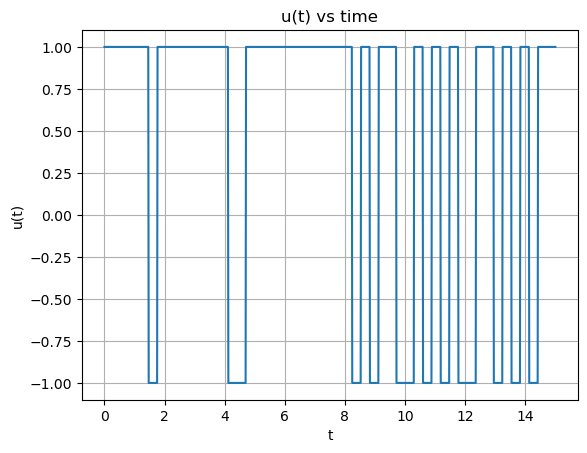

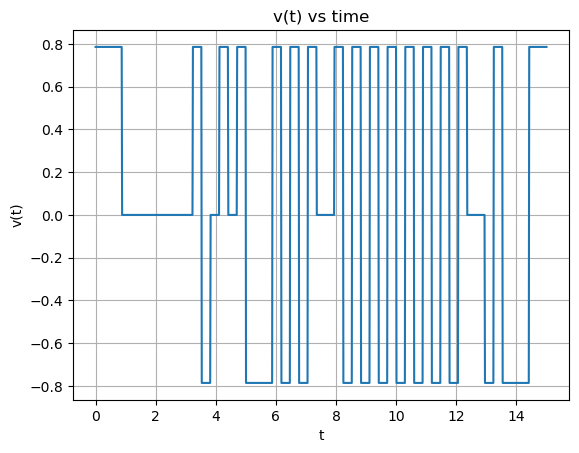

In [32]:
us=[2*(0.5-i%2) for i in u_t]
vs=[(1-i//2)*np.pi/4 for i in u_t]

u=[]
v=[]
for i in range(len(us)):
    for j in range(20):
        u.append(us[i])
        v.append(vs[i])
        
x = np.linspace(0, T, (N+1)*20)
plt.plot(x, u)
plt.xlabel('t')
plt.ylabel('u(t)')
plt.title("u(t) vs time")
plt.grid()
plt.show()

x = np.linspace(0, T, (N+1)*20)
plt.plot(x, v)
plt.xlabel('t')
plt.ylabel('v(t)')
plt.title("v(t) vs time")
plt.grid()
plt.show()

## Last Trajectory


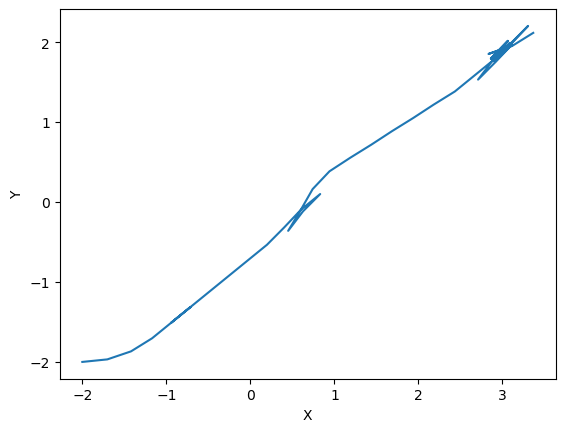

In [33]:
obs=np.array(observation_t)
obs=obs[:,[0,1]]
plt.plot(obs[:,0],obs[:,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

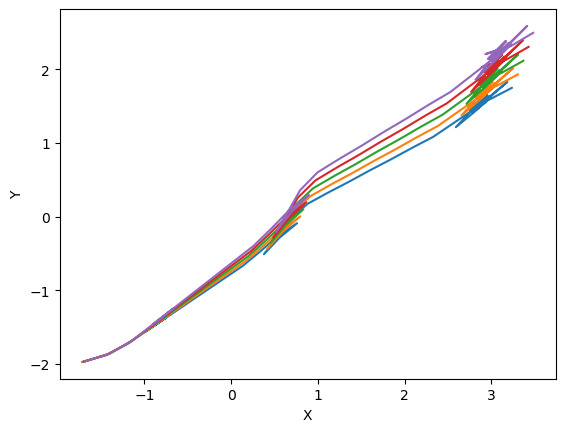

2.2689493925341657


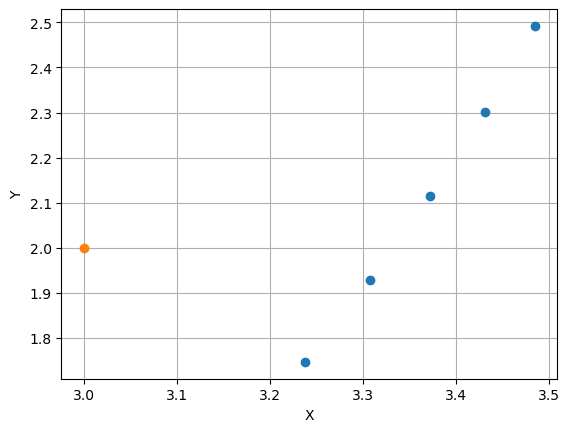

In [34]:
pos=[]
for i in range(num_system):
    obs=np.array(position_t[i])
    obs=obs[:,[0,1]]
    plt.plot(obs[:,0],obs[:,1])
    pos.append(obs[-1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
print(reward_raw(np.array(pos)))

cord_x=[]
cord_y=[]
for i in range(num_system):
    cord_x.append(pos[i][0])
    cord_y.append(pos[i][1])
plt.plot(np.array(cord_x),np.array(cord_y), 'o')
plt.plot(np.array([3]),np.array([2]), 'o')
#plt.plot(obs[-1,0],obs[-1,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.show()


## Best Trajectory

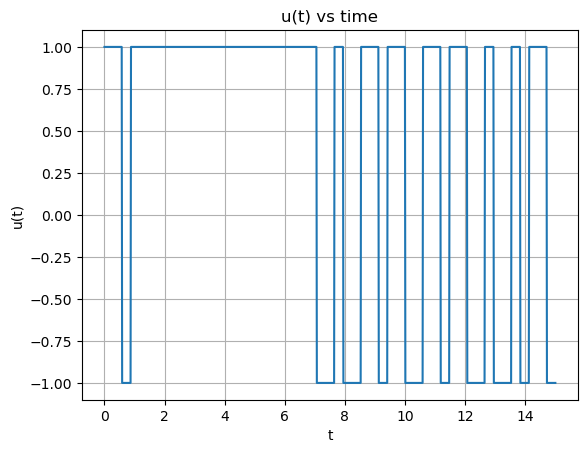

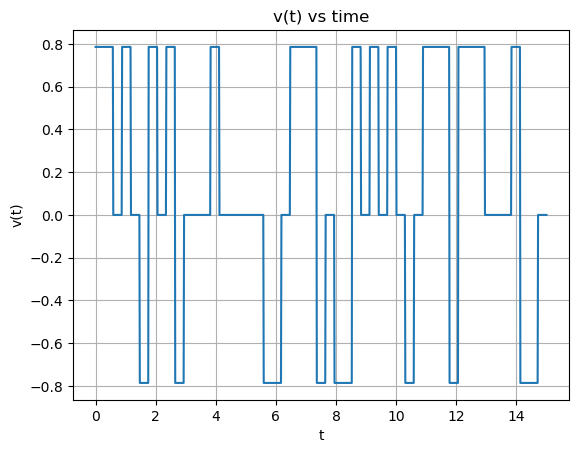

In [35]:
us=[2*(0.5-i%2) for i in best_u]
vs=[(1-i//2)*np.pi/4 for i in best_u]

u=[]
v=[]
for i in range(len(us)):
    for j in range(20):
        u.append(us[i])
        v.append(vs[i])

x = np.linspace(0, T, (N+1)*20)
plt.plot(x, u)
plt.xlabel('t')
plt.ylabel('u(t)')
plt.title("u(t) vs time")
plt.grid()
plt.show()

x = np.linspace(0, T, (N+1)*20)
plt.plot(x, v)
plt.xlabel('t')
plt.ylabel('v(t)')
plt.title("v(t) vs time")
plt.grid()
plt.show()

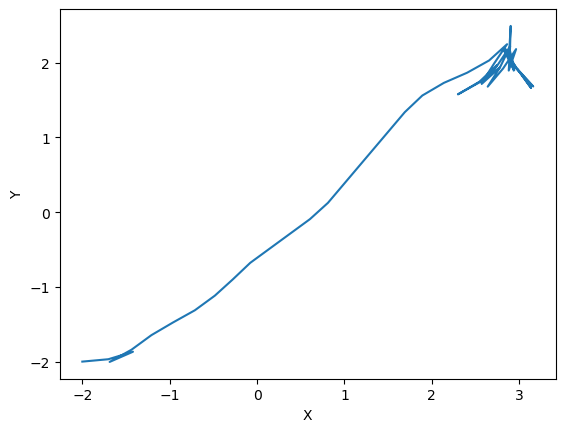

In [36]:
obs=np.array(best_obs)
obs=obs[:,[0,1]]
plt.plot(obs[:,0],obs[:,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

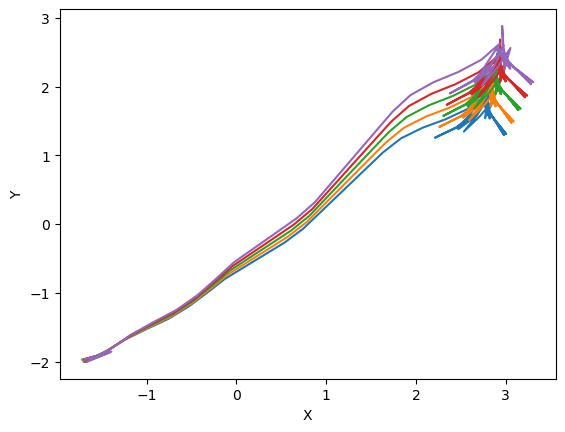

1.2685224644366535


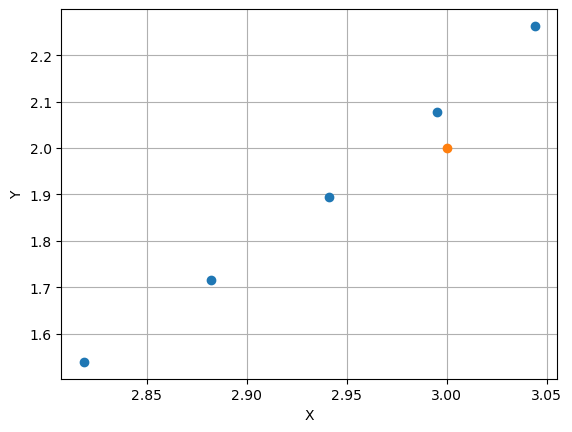

In [37]:
pos=[]
for i in range(num_system):
    obs=np.array(best_pos[i])
    obs=obs[:,[0,1]]
    plt.plot(obs[:,0],obs[:,1])
    pos.append(obs[-1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
print(reward_raw(np.array(pos)))

pos=[]
for i in range(num_system):
    obs=np.array(best_pos[i])
    obs=obs[:,[0,1]]
    #plt.plot(obs[:,0],obs[:,1])
    pos.append(obs[-1])

cord_x=[]
cord_y=[]
for i in range(num_system):
    cord_x.append(pos[i][0])
    cord_y.append(pos[i][1])
plt.plot(np.array(cord_x),np.array(cord_y), 'o')
plt.plot(np.array([3]),np.array([2]), 'o')
#plt.plot(obs[-1,0],obs[-1,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.show()

## Pure Exploitation Trajectory

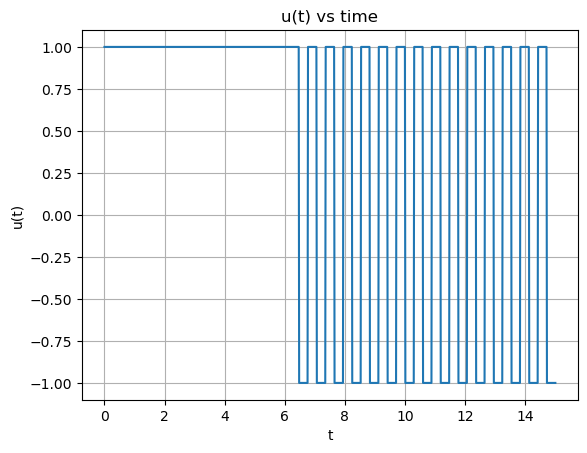

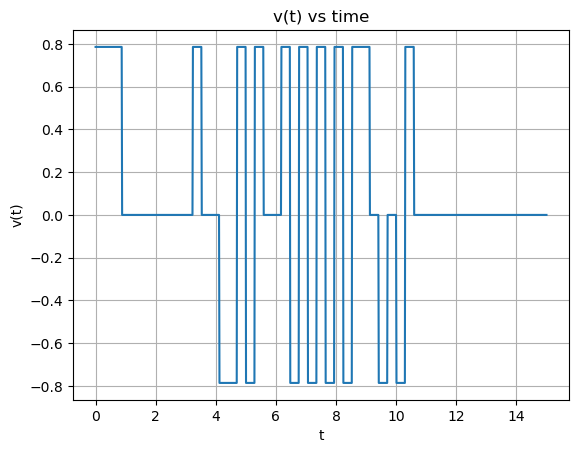

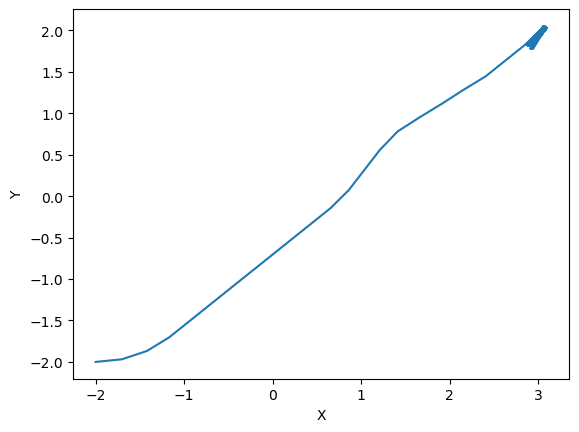

In [38]:
position=np.array([[-2,-2,0] for _ in range(num_system)])
observation=observe(position)
u_t=[]
observation_t=[observation]
position_t=[[] for i in range(num_system)]

for time in range(N+1):           
    
    #print(candidates_u)
    u_k = decide_u_exploitation(gpr_list[time],flags,observation)
    position_new = next_step(position,action_set[u_k])
    observation_new = observe(position_new)
    r = reward(observation_new)
    '''
    if explo:
        history_su[u_k] = np.concatenate((history_su[u_k], observation.reshape(-1,5)))
        history_r[u_k] = np.concatenate((history_r[u_k],np.array([r])))
    '''
    observation=observation_new
    position=position_new
    u_t.append(u_k)
    observation_t.append(observation)
    for i in range(num_system):
        position_t[i].append(position[i])
    '''
    if time%((N+1)//3+1)==0:
        for i in range(6):
            gpr_list[i]=GaussianProcessRegressor(alpha=1e-8).fit(history_su[i], history_r[i].reshape(-1,1))
    '''
    
us=[2*(0.5-i%2) for i in u_t]
vs=[(1-i//2)*np.pi/4 for i in u_t]

u=[]
v=[]
for i in range(len(us)):
    for j in range(20):
        u.append(us[i])
        v.append(vs[i])
    

x = np.linspace(0, T, (N+1)*20)
plt.plot(x, u)
plt.xlabel('t')
plt.ylabel('u(t)')
plt.title("u(t) vs time")
plt.grid()
plt.show()

x = np.linspace(0, T, (N+1)*20)
plt.plot(x, v)
plt.xlabel('t')
plt.ylabel('v(t)')
plt.title("v(t) vs time")
plt.grid()
plt.show()

obs=np.array(observation_t)
obs=obs[:,[0,1]]
plt.plot(obs[:,0],obs[:,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

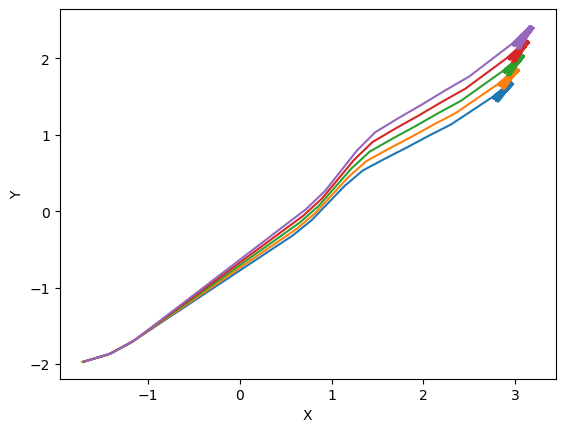

1.4247012644199222


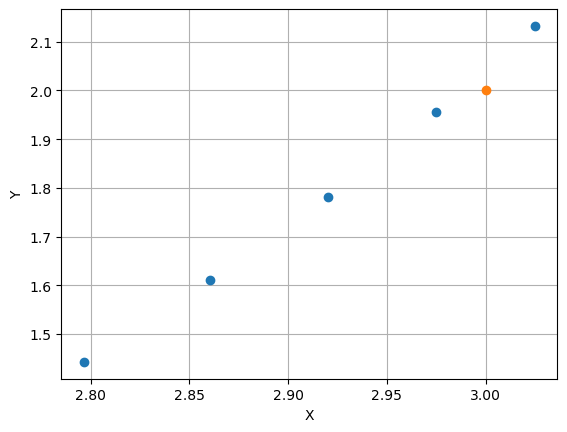

In [39]:
pos=[]
for i in range(num_system):
    obs=np.array(position_t[i])
    obs=obs[:,[0,1]]
    plt.plot(obs[:,0],obs[:,1])
    pos.append(obs[-1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
print(reward_raw(position))

cord_x=[]
cord_y=[]
for i in range(num_system):
    cord_x.append(pos[i][0])
    cord_y.append(pos[i][1])
plt.plot(np.array(cord_x),np.array(cord_y), 'o')
plt.plot(np.array([3]),np.array([2]), 'o')
#plt.plot(obs[-1,0],obs[-1,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.show()